<a href="https://colab.research.google.com/github/changhoonhahn/provabgs/blob/main/nb/nmfburst_decoder_valid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# decorder for `nmfburst` SPS model
Instead of using the PCA encoding a training a neural net to predict PCA coefficients, I'm going to try to train a decoder directly from the (theta, SED) data set. 

notebook has code lifted from: 
- https://github.com/stephenportillo/SDSS-VAE/blob/master/trainVAE.py
- https://github.com/stephenportillo/SDSS-VAE/blob/master/InfoVAE.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/provabgs

/content/drive/My Drive/provabgs


In [3]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [4]:
wave = np.load('wave_fsps.npy')

In [5]:
theta = np.load("fsps.nmfburst.theta.test.npy")

In [6]:
# whiten the spectra
mu_lnspec = np.mean(np.load('fsps.nmfburst.lnspectrum.test.npy'), axis=0)
sig_lnspec = np.std(np.load('fsps.nmfburst.lnspectrum.test.npy'), axis=0)

lnspec_white = (np.load('fsps.nmfburst.lnspectrum.test.npy') - mu_lnspec)/sig_lnspec

In [7]:
n_theta = theta.shape[1]
n_lnspec = lnspec_white.shape[1]
print('n theta = %i' % n_theta)
print('n ln(spec) = %i' % n_lnspec)

n theta = 12
n ln(spec) = 4469


In [8]:
Ntrain = int(float(theta.shape[0]) * 0.9)
Ntest = theta.shape[0] - Ntrain
print('Ntrain = %i' % Ntrain)
print('Ntest = %i' % Ntest)

Ntrain = 90000
Ntest = 10000


In [9]:
class Decoder(nn.Module): 
    def __init__(self, nfeat=1000, ncode=5, nhidden=128, nhidden2=35, dropout=0.2):
        super(Decoder, self).__init__()
        
        self.ncode = int(ncode)
        
        self.decd = nn.Linear(ncode, nhidden2)
        self.d3 = nn.Dropout(p=dropout)
        self.dec2 = nn.Linear(nhidden2, nhidden)
        self.d4 = nn.Dropout(p=dropout)
        self.outp = nn.Linear(nhidden, nfeat)
        
    def decode(self, x):
        x = self.d3(F.leaky_relu(self.decd(x)))
        x = self.d4(F.leaky_relu(self.dec2(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        return self.decode(x)
    
    def loss(self, x, y):
        recon_y = self.forward(x)
        MSE = torch.sum(0.5 * (y - recon_y).pow(2))
        return MSE

In [10]:
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(theta[Ntrain:], dtype=torch.float32), torch.tensor(lnspec_white[Ntrain:], dtype=torch.float32)),
    batch_size=Ntest)

In [24]:
model = torch.load('decoder.pth')

In [25]:
for test_data in test_loader:
  theta_test, lnspec_white_test = test_data
  lnspec_white_recon = model.forward(theta_test)

  lnspec_test = sig_lnspec * (lnspec_white_test.detach().numpy() + mu_lnspec)
  lnspec_recon = sig_lnspec * (lnspec_white_recon.detach().numpy() + mu_lnspec)

(2305.0, 11025.0)

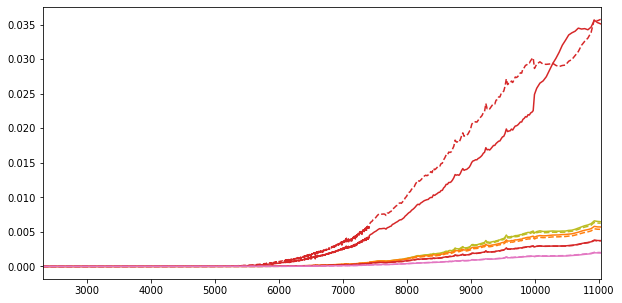

In [26]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in np.random.choice(Ntest, size=5, replace=False): 
  sub.plot(wave, np.exp(lnspec_recon[i]), c='C%i' % i)
  sub.plot(wave, np.exp(lnspec_test[i]), c='C%i' % i, ls='--')
sub.set_xlim(wave.min(), wave.max())

(-0.1, 0.1)

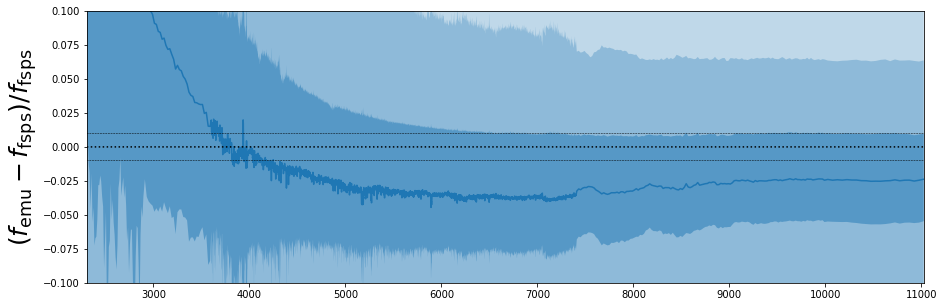

In [27]:
frac_dspectrum = 1. - np.exp(lnspec_recon - lnspec_test)
frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, 
                                          [0.0005, 0.005, 0.025, 0.16, 0.5, 0.84, 0.975, 0.995, 0.9995], axis=0)

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.fill_between(wave, frac_dspectrum_quantiles[0],
        frac_dspectrum_quantiles[-1], fc='C0', ec='none', alpha=0.1, label='99.9%')
sub.fill_between(wave, frac_dspectrum_quantiles[1],
        frac_dspectrum_quantiles[-2], fc='C0', ec='none', alpha=0.2, label='99%')
sub.fill_between(wave, frac_dspectrum_quantiles[2],
        frac_dspectrum_quantiles[-3], fc='C0', ec='none', alpha=0.3, label='95%')
sub.fill_between(wave, frac_dspectrum_quantiles[3],
        frac_dspectrum_quantiles[-4], fc='C0', ec='none', alpha=0.5, label='68%')
sub.plot(wave, frac_dspectrum_quantiles[4], c='C0', ls='-') 
sub.plot(wave, np.zeros(len(wave)), c='k', ls=':') 

# mark +/- 1%
sub.plot(wave, 0.01 * np.ones(len(wave)), c='k', ls='--', lw=0.5)
sub.plot(wave, -0.01 * np.ones(len(wave)), c='k', ls='--', lw=0.5)

sub.set_xlim(wave.min(), wave.max())
sub.set_ylabel(r'$(f_{\rm emu} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
sub.set_ylim(-0.1, 0.1) 